In [4]:
import numpy as np
import rasterio as rio 
import matplotlib.pyplot as plt
import pandas as pd
import math

## Microscale calculations

In [5]:
# Read raster with two bands 
# the first band is the water depth (binary 0 and 1), all pixesl with water depth > 1 cm are 1 and others are 0
# the second band is the topographic wetness index (TWI) 
# you can calculate the TWI in python or GIS
src= rio.open('composite_TELEMAC_TWI_100.tif')
# print number of bands
src.count

2

In [6]:
# read bands
array = src.read()

In [7]:
# convert to a DataFrame
import pandas as pd
df = pd.DataFrame()
df['waterdepth'] = array[0].ravel() 
df['TWI'] = array[1].ravel() 
df.head()

,waterdepth,TWI
0,99999.0,99999.0
1,99999.0,99999.0
2,99999.0,99999.0
3,99999.0,99999.0
4,99999.0,99999.0


In [8]:
# remove pixels with no value (no value pixels has value = 99999 )
df=df[df.waterdepth <99999]
df=df[df.TWI < 99999] 
df

,waterdepth,TWI
24739,1.0,3.704139
24740,1.0,3.503064
29391,0.0,6.196782
29392,0.0,3.446129
29393,0.0,3.476227
...,...,...
12538377,1.0,6.847323
12538378,1.0,3.274583
12538379,1.0,6.912879
12538380,1.0,4.083636


In [9]:
# print the statistics of the two variables (water depth and TWI)
df.describe()

,waterdepth,TWI
count,6.253454e+06,6.253454e+06
mean,5.168427e-01,5.284087e+00
std,4.997163e-01,2.579302e+00
min,0.000000e+00,-1.477638e+00
25%,0.000000e+00,3.381277e+00
50%,1.000000e+00,4.534213e+00
75%,1.000000e+00,6.825071e+00
max,1.000000e+00,2.891914e+01


In [11]:
# we will loop over all the TWI values
# we need to get the closest integer to the TWI and mulipy it by 10 to use in the for loop
# we get the original values back by dividing it by 10 inside the loop 
min_TWI=math.ceil(np.min(df['TWI'])*10)
min_TWI

-14

In [12]:
max_TWI=math.floor(np.max(df['TWI'])*10)
max_TWI

289

In [54]:
# Estimate the TWI thresholds and the corresponding values

TWI_list=[] # TWI thresholds
#cross_table=[]
NotFlooded=[] # not flooded based on water depth and TWI threshold obtained from the contingency table
Flooded=[] #  flooded based on water depth and TWI threshold obtained from the contingency table
for i in range(min_TWI,max_TWI):
    TWI_threshold=i/10
    df['TWI_threshold'] = np.where(df['TWI']> TWI_threshold, 1, 0)
    x=pd.crosstab(df.waterdepth,df.TWI_threshold)
    #cross_table.append([('TWI_'+str(TWI_threshold)),x])
    TWI_list.append(TWI_threshold)
    NotFlooded.append(x.iloc[0,0])
    Flooded.append(x.iloc[1,1])
        #print(x)
    #print(x.iloc[0,0])
    #print(x.iloc[1,1])
    

In [55]:
# Microscale
src= rio.open('TWI_micro.tif')
# number of bands
src.count

1

In [56]:
# read bands
array = src.read()
array.max()



99999.0

In [57]:
# replace no value data (99999) with nan
array[array==99999]=np.nan
array.max()

nan

In [58]:
# calculate the area above a given thresold 
TWI_threshold_Area_micro=[]
for i in range(min_TWI,max_TWI):
    j=i/10
    TWI_area=(array > j).sum()
    TWI_threshold_Area_micro.append(TWI_area)
    #print(TWI_area)
    #break

## Mesoscale calculation

In [18]:
src= rio.open('TWI_mesoscale.tif')
# number of bands
src.count

1

In [19]:
# read bands
mesoscale_array = src.read()
mesoscale_array[mesoscale_array==99999]=np.nan
mesoscale_array.max()

nan

In [20]:
TWI_threshold_Area_meso=[]
for i in range(min_TWI,max_TWI):
    j=i/10
    TWI_area=(mesoscale_array > j).sum()
    TWI_threshold_Area_meso.append(TWI_area)
    #print(TWI_area)

In [59]:
# here we used the calculated values to calculate the three main equations in the paper to estimate the TWI threshold corresponding to the maximum likelihood

summary=pd.DataFrame()
summary['TWI_threshold']= TWI_list # TWI threshold value

#  the probability that a certain pixel within the spatial window W is identified as IN on the condition that it is FP
# and  P(IN|FP, τ, W) indicates the probability that a certain pixel within the spatial window W is identified as IN on the condition that it is FP, for a given value of τ.
summary['TWI_threshold_Floodedarea_micro']=TWI_threshold_Area_micro
summary['P(FP)| tau_micro']= summary.TWI_threshold_Floodedarea_micro/summary['TWI_threshold_Floodedarea_micro'][0]
summary['Both_Flooded_micro'] = Flooded
summary["P(IN|FP,tau)"]=summary["Both_Flooded_micro"]/summary["TWI_threshold_Floodedarea_micro"] #2

summary["P(FP')| tau_micro"]= 1-summary['P(FP)| tau_micro']
summary['TWI_threshold_NotFloodedarea_micro']=summary['TWI_threshold_Floodedarea_micro'][0]-summary["TWI_threshold_Floodedarea_micro"]
summary['Both_NotFlooded_micro'] = NotFlooded
summary["P(IN'|FP',tau)"]=summary["Both_NotFlooded_micro"]/summary["TWI_threshold_NotFloodedarea_micro"] #2'



#the probability that a certain pixel within the spatial window W is FP and FP, respectively, conditioned on a given value of τ.

summary['TWI_threshold_Floodedarea_meso']=TWI_threshold_Area_meso
summary['P(FP)| tau_meso']= summary.TWI_threshold_Floodedarea_meso/summary['TWI_threshold_Floodedarea_meso'][0] #1
summary["P(FP')| tau_meso" ]= 1-summary['P(FP)| tau_meso'] #1'

#  the probability that a certain pixel within a spatial window
# W is identified both as inundated IN (based on the calculated inundation maps from
# TELEMAC-2D model) and FP (based on the TWI method), and conditioned on a given
# value of τ. Furthermore, P(FP, IN|τ, W) indicates the probability that a certain pixel within
# the spatial window W is neither identified as IN nor as FP conditioned on a given τ.

summary['P(FP,IN | tau)']=summary['P(FP)| tau_meso']*summary["P(IN|FP,tau)"] #3
summary["P(FP',IN' | tau)"]=summary["P(FP')| tau_meso"]*summary["P(IN'|FP',tau)"]    #3'

# maximum likelihood function
summary['likelihood']=summary['P(FP,IN | tau)']+summary["P(FP',IN' | tau)"]
summary


,TWI_threshold,TWI_threshold_Floodedarea_micro,P(FP)| tau_micro,Both_Flooded_micro,"P(IN|FP,tau)",P(FP')| tau_micro,TWI_threshold_NotFloodedarea_micro,Both_NotFlooded_micro,"P(IN'|FP',tau)",TWI_threshold_Floodedarea_meso,P(FP)| tau_meso,P(FP')| tau_meso,"P(FP,IN | tau)","P(FP',IN' | tau)",likelihood
0,-1.4,6304509,1.000000e+00,3232049,0.512657,0.000000,0,11,inf,1132158189,1.000000e+00,0.000000,5.126567e-01,NaN,NaN
1,-1.3,6304497,9.999981e-01,3232046,0.512657,0.000002,12,19,1.583333,1132153888,9.999962e-01,0.000004,5.126553e-01,0.000006,0.512661
2,-1.2,6304455,9.999914e-01,3232032,0.512658,0.000009,54,42,0.777778,1132148940,9.999918e-01,0.000008,5.126542e-01,0.000006,0.512661
3,-1.1,6304416,9.999852e-01,3232020,0.512660,0.000015,93,69,0.741935,1132142816,9.999864e-01,0.000014,5.126527e-01,0.000010,0.512663
4,-1.0,6304370,9.999780e-01,3232001,0.512660,0.000022,139,94,0.676259,1132136618,9.999809e-01,0.000019,5.126507e-01,0.000013,0.512664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,28.4,2,3.172333e-07,2,1.000000,1.000000,6304507,3021402,0.479245,109,9.627630e-08,1.000000,9.627630e-08,0.479245,0.479245
299,28.5,2,3.172333e-07,2,1.000000,1.000000,6304507,3021402,0.479245,100,8.832688e-08,1.000000,8.832688e-08,0.479245,0.479245
300,28.6,2,3.172333e-07,2,1.000000,1.000000,6304507,3021402,0.479245,91,8.037746e-08,1.000000,8.037746e-08,0.479245,0.479245
301,28.7,1,1.586166e-07,1,1.000000,1.000000,6304508,3021402,0.479245,82,7.242804e-08,1.000000,7.242804e-08,0.479245,0.479245


## Estimate the maximum liklihood value and the 95 confidence interveal

In [60]:
# let us make a new dataframe which includes only the data that we need
df2=pd.DataFrame()
df2['τ']=summary['TWI_threshold'] # TWI threshold
df2['L(τ│W)']=summary['likelihood'] # Maximum likelihood coressponding to each TWI theshold value
df2

,τ,L(τ│W)
0,-1.4,NaN
1,-1.3,0.512661
2,-1.2,0.512661
3,-1.1,0.512663
4,-1.0,0.512664
...,...,...
298,28.4,0.479245
299,28.5,0.479245
300,28.6,0.479245
301,28.7,0.479245


In [61]:
df2['L(τ│W)'].max() # maximum likelihood value

0.6270739909499667

In [62]:
# TWI threshold corresponding to the maximum likelihood value
df2.loc[df2['L(τ│W)'] == df2['L(τ│W)'].max(),'τ']

67    5.3
Name: τ, dtype: float64

In [63]:
# 95 quantile interval
df2['L(τ│W)'].quantile(0.95)


0.6207050720504971

In [64]:
df2.loc[df2['L(τ│W)'] >= df2['L(τ│W)'].quantile(0.95),'τ']


62    4.8
63    4.9
64    5.0
65    5.1
66    5.2
67    5.3
68    5.4
69    5.5
70    5.6
71    5.7
72    5.8
73    5.9
74    6.0
75    6.1
76    6.2
77    6.3
Name: τ, dtype: float64

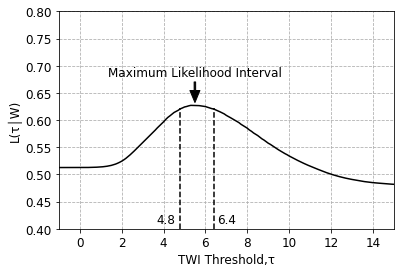

In [65]:
ax=df2.plot(kind='line', x='τ',y='L(τ│W)', color='k',zorder=10,fontsize=12)
size=12
plt.xlim(-1, 15)
plt.ylim(0.4, 0.8)
plt.xlabel('TWI Threshold,τ',fontsize=12)
plt.ylabel('L(τ│W)',fontsize=12)
plt.axvline(x=4.8, ymin=0, ymax=0.555, color='k', linestyle='--',zorder=5)
plt.axvline(x=6.4, ymin=0, ymax=0.555, color='k', linestyle='--',zorder=5)
threshold=0.72
plt.grid(linestyle='--')
ax.set_axisbelow(True)


plt.annotate('4.8',
            xy=(4.6, 0.401), xycoords='data',
            xytext=(-20, 5), textcoords='offset points',fontsize=size)
plt.annotate('6.4',
            xy=(7.5, 0.401), xycoords='data',
            xytext=(-20, 5), textcoords='offset points',fontsize=size)
'''plt.annotate('Maximum Likelihood Interval',
             xy=(4, 0.88), xycoords='data',
             xytext=(0, -20), textcoords='offset points')'''
plt.annotate('Maximum Likelihood Interval', xy=(5.5, 0.63),  xycoords='data',
            xytext=(9.65, 0.7), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=10),
            horizontalalignment='right', verticalalignment='top',fontsize=size
            )
ax.get_legend().remove()

#plt.fill_betweenx(y=df2['L(τ│W)'],x1=4.8,x2=6.4,where=df2['L(τ│W)']<0.63,color='silver',zorder=0)
plt.savefig('Maximum_Likelihood.pdf')